# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

import torchvision
import torchvision.datasets as dset
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Pytorch tutorial

### Pytorch tensor

In [4]:
x = torch.empty(5, 3)
print(x)

tensor([[-7.4240e-35,  4.5556e-41,  1.2059e-36],
        [ 0.0000e+00,  1.4178e+02,  4.5556e-41],
        [ 1.1996e-36,  0.0000e+00,  1.1996e-36],
        [ 0.0000e+00,  3.7415e-43,  4.5556e-41],
        [ 8.9683e-44,  0.0000e+00,  1.7937e-43]])


In [5]:
x = torch.rand(5, 3)
print(x)

tensor([[0.5838, 0.0435, 0.3676],
        [0.6813, 0.3565, 0.5657],
        [0.1262, 0.8064, 0.5536],
        [0.8061, 0.6555, 0.5306],
        [0.7796, 0.9546, 0.7445]])


In [6]:
x = torch.zeros(5, 3, dtype=torch.long)
print(x)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


In [7]:
x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


In [8]:
x = torch.randn_like(x, dtype=torch.float)    # override dtype!
print(x)  

tensor([ 0.3618, -0.1347])


In [11]:
x.size()

torch.Size([2])

In [13]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())
print(y)

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])
tensor([-0.0552,  0.4317,  0.7155,  1.2822, -0.9484,  0.6563,  0.5390,  0.5729,
         0.6348, -0.0833,  1.4096, -1.3007, -0.1246, -0.9477, -1.5801,  1.5747])


In [14]:
torch.cuda.is_available()

True

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y

In [18]:
print(z)
print(z.to("cpu", torch.double)) 

tensor([[ 0.9448,  1.4317,  1.7155,  2.2822],
        [ 0.0516,  1.6563,  1.5390,  1.5729],
        [ 1.6348,  0.9167,  2.4096, -0.3007],
        [ 0.8754,  0.0523, -0.5801,  2.5747]], device='cuda:0')
tensor([[ 0.9448,  1.4317,  1.7155,  2.2822],
        [ 0.0516,  1.6563,  1.5390,  1.5729],
        [ 1.6348,  0.9167,  2.4096, -0.3007],
        [ 0.8754,  0.0523, -0.5801,  2.5747]], dtype=torch.float64)


### Pytorch Autograd

In [21]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
y = x + 2
print(y)
print(y.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [22]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [24]:
out.backward()

In [25]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [23]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


In [26]:
b.backward()

In [27]:
a.grad

tensor([[ 1.1120, -9.0869],
        [-0.5763, -4.9394]])

In [28]:
x = torch.randn(3, requires_grad=True)
y = x * 2
while y.data.norm() < 1000:
    y = y * 2
print(y)

tensor([  114.1148, -1126.6935,   317.1498], grad_fn=<MulBackward0>)


### Pytorch nn

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 1, 3, 3])


In [35]:
input_ = torch.randn(1, 1, 32, 32)
out = net(input_)
print(out)

net.zero_grad()
out.backward(torch.randn(1, 10))

tensor([[-0.0617, -0.1158,  0.0818,  0.1675, -0.0164, -0.0845,  0.0591,  0.0493,
          0.0757, -0.0628]], grad_fn=<AddmmBackward>)


In [42]:
output = net(input_)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.4515, grad_fn=<MseLossBackward>)


In [46]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  

In [47]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0030,  0.0183, -0.0040, -0.0137,  0.0154,  0.0105])


In [50]:
net.parameters()

<generator object Module.parameters at 0x7efdfc299ca8>

In [51]:
# weight = weight - learning_rate * gradient
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [57]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input_)
loss = criterion(output, target)
print(net.conv1.bias.grad)
print(net.conv1.bias)
loss.backward()
optimizer.step()    # Does the update
print(net.conv1.bias.grad)
print(net.conv1.bias)

tensor([0., 0., 0., 0., 0., 0.])
Parameter containing:
tensor([-0.1715,  0.0292,  0.2621, -0.2635, -0.1059,  0.0968],
       requires_grad=True)
tensor([-0.0061,  0.0088, -0.0124, -0.0080, -0.0059, -0.0037])
Parameter containing:
tensor([-0.1715,  0.0291,  0.2622, -0.2634, -0.1059,  0.0968],
       requires_grad=True)


### Pytorch Classifier

In [61]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

9.5%

limit_output extension: Maximum message size of 10000 exceeded with 10001 characters

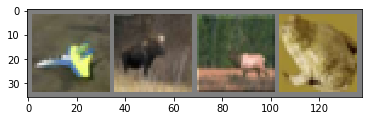

plane  deer  deer  frog


In [62]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [64]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 1.911
[1,  6000] loss: 1.697
[1,  8000] loss: 1.580
[1, 10000] loss: 1.504
[1, 12000] loss: 1.458
[2,  2000] loss: 1.400
[2,  4000] loss: 1.368
[2,  6000] loss: 1.374
[2,  8000] loss: 1.318
[2, 10000] loss: 1.283
[2, 12000] loss: 1.272
Finished Training


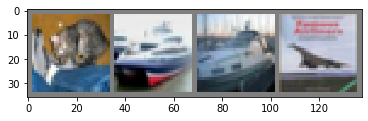

GroundTruth:    cat  ship  ship plane


In [65]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [66]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


In [70]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [71]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 82 %
Accuracy of  bird : 43 %
Accuracy of   cat : 33 %
Accuracy of  deer : 32 %
Accuracy of   dog : 48 %
Accuracy of  frog : 80 %
Accuracy of horse : 67 %
Accuracy of  ship : 51 %
Accuracy of truck : 51 %


In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [79]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

GeForce GTX 1080 Ti
500736
2097152


In [80]:
net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.145
[1,  4000] loss: 1.766
[1,  6000] loss: 1.583
[1,  8000] loss: 1.480
[1, 10000] loss: 1.438
[1, 12000] loss: 1.385
[2,  2000] loss: 1.280
[2,  4000] loss: 1.259
[2,  6000] loss: 1.239
[2,  8000] loss: 1.210
[2, 10000] loss: 1.193
[2, 12000] loss: 1.164
Finished Training


## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
transformer = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                                std=[0.20,0.20,0.20])                           
                       ])
data_train = dset.SVHN('./data/', split='train',
                       transform=transformer
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transformer)

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=8)
val_loader = torch.utils.data.DataLoader(data_train, 
                                         batch_size=batch_size,
                                         sampler=val_sampler,
                                         num_workers=8)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, 
                scheduler=None,
                use_gpu=False):    
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        
        if scheduler is not None:
            # Decay Learning Rate
            scheduler.step()
            print('Epoch:', epoch,'LR:', scheduler.get_lr())
        #if use_gpu:
        #    model.cuda()    
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
                
            prediction = model(x)    
            loss_value = loss(prediction, y)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader, use_gpu)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader, use_gpu=False):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        if use_gpu:
            x = x.cuda()
            y = y.cuda()            
        prediction = model(x)    
            
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]    
    
    return float(correct_samples) / total_samples

In [6]:
val_loader

In [7]:
for i_step, (x, y) in enumerate(val_loader):
    print(i_step, x, y)
    if i_step == 5:
        break

0 tensor([[[[ 1.5755,  1.5951,  1.7716,  ..., -0.2480, -0.4833, -0.6206],
          [ 1.5951,  1.6147,  1.6147,  ...,  0.0265, -0.2676, -0.4833],
          [ 1.6147,  1.6343,  1.6147,  ...,  0.3598, -0.0324, -0.3461],
          ...,
          [ 1.5755,  1.5951,  1.6343,  ..., -0.4049, -0.5422, -0.8167],
          [ 1.5755,  1.6147,  1.6539,  ..., -0.6206, -0.7578, -0.9539],
          [ 1.6343,  1.6931,  1.6735,  ..., -0.7971, -0.8755, -0.9735]],

         [[ 1.6039,  1.6039,  1.7608,  ..., -0.2196, -0.4353, -0.5529],
          [ 1.6235,  1.6627,  1.6235,  ...,  0.1137, -0.2000, -0.4157],
          [ 1.6431,  1.6824,  1.6824,  ...,  0.4078,  0.0157, -0.2980],
          ...,
          [ 1.6431,  1.6431,  1.6431,  ..., -0.2196, -0.3961, -0.6902],
          [ 1.6431,  1.6627,  1.6431,  ..., -0.4549, -0.5922, -0.8078],
          [ 1.6627,  1.6824,  1.6431,  ..., -0.6314, -0.7294, -0.8471]],

         [[ 1.4343,  1.3951,  1.5716,  ...,  0.1402, -0.0755, -0.2324],
          [ 1.4539,  1.4343,

In [19]:
pred = nn_model(x)
_, inds = torch.max(pred,dim=1)
torch.sum(inds == y)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [17]:
torch.max(pred,dim=1)

torch.return_types.max(
values=tensor([0.2149, 0.2590, 0.2057, 0.2266, 0.2593, 0.3734, 0.0993, 0.3129, 0.2244,
        0.4295, 0.2357, 0.4726, 0.3160, 0.0640, 0.1945, 0.0656, 0.4293, 0.2596,
        0.3367, 0.2427, 0.3639, 0.4950, 0.1374, 0.2095, 0.2193, 0.3297, 0.3980,
        0.3489, 0.2939, 0.4270, 0.3111, 0.1892, 0.1363, 0.4416, 0.2225, 0.5282,
        0.2451, 0.2699, 0.3558, 0.3120, 0.6010, 0.4424, 0.1932, 0.2219, 0.5965,
        0.3066, 0.3843, 0.2356, 0.1903, 0.1592, 0.2143, 0.1978, 0.2492, 0.0886,
        0.1569, 0.2378, 0.3820, 0.1953, 0.4098, 0.1912, 0.1411, 0.4216, 0.3261,
        0.1588], grad_fn=<MaxBackward0>),
indices=tensor([1, 9, 1, 2, 2, 1, 7, 8, 2, 1, 1, 4, 2, 1, 6, 2, 1, 8, 9, 1, 2, 1, 2, 8,
        8, 1, 8, 1, 1, 1, 6, 5, 6, 2, 5, 1, 1, 1, 9, 8, 1, 1, 1, 1, 1, 1, 8, 2,
        1, 1, 8, 8, 1, 9, 1, 1, 8, 8, 2, 9, 1, 4, 1, 1]))

In [22]:
%%time
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.459607, Train accuracy: 0.575811, Val accuracy: 0.609788
Average loss: 1.381460, Train accuracy: 0.613162, Val accuracy: 0.621732
Average loss: 1.350160, Train accuracy: 0.630959, Val accuracy: 0.621118
CPU times: user 5min 6s, sys: 703 ms, total: 5min 7s
Wall time: 30.3 s


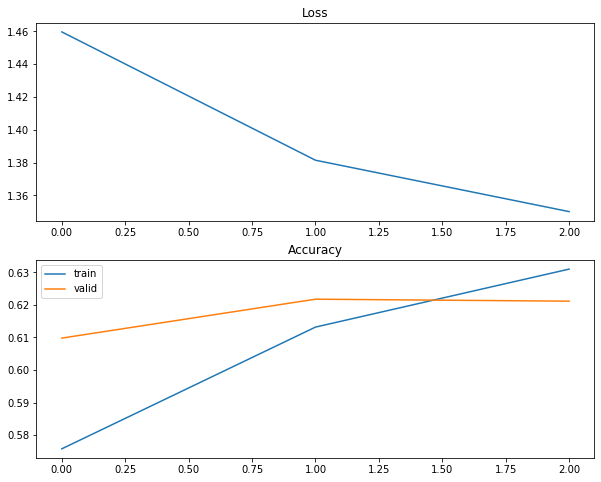

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [24]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),     
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [25]:
%%time
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.182658, Train accuracy: 0.190578, Val accuracy: 0.207563
Average loss: 1.993936, Train accuracy: 0.278402, Val accuracy: 0.353491
Average loss: 1.778691, Train accuracy: 0.389585, Val accuracy: 0.412668
Average loss: 1.698148, Train accuracy: 0.422534, Val accuracy: 0.433349
Average loss: 1.674793, Train accuracy: 0.437140, Val accuracy: 0.434783
CPU times: user 8min 24s, sys: 923 ms, total: 8min 25s
Wall time: 49.8 s


Добавьте слой с Batch Normalization

In [26]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),    
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)

In [27]:
%%time
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.120510, Train accuracy: 0.293417, Val accuracy: 0.446864
Average loss: 1.802634, Train accuracy: 0.494250, Val accuracy: 0.542420
Average loss: 1.622786, Train accuracy: 0.563662, Val accuracy: 0.591427
Average loss: 1.512927, Train accuracy: 0.593165, Val accuracy: 0.610334
Average loss: 1.440396, Train accuracy: 0.611968, Val accuracy: 0.633950
CPU times: user 9min 11s, sys: 1.16 s, total: 9min 12s
Wall time: 54.4 s


Добавьте уменьшение скорости обучения по ходу тренировки.

In [7]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. 
# You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
lr_lambda = lambda x: 0.5**(x//2)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [79]:
%%time
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 5, lr_scheduler)

Epoch: 0 LR: [0.001]
Average loss: 2.132081, Train accuracy: 0.290568, Val accuracy: 0.434305
Epoch: 1 LR: [0.0005]
Average loss: 1.891045, Train accuracy: 0.466608, Val accuracy: 0.508634
Epoch: 2 LR: [0.0005]
Average loss: 1.777014, Train accuracy: 0.524417, Val accuracy: 0.557027
Epoch: 3 LR: [0.00025]
Average loss: 1.695888, Train accuracy: 0.563850, Val accuracy: 0.579892
Epoch: 4 LR: [0.00025]
Average loss: 1.650672, Train accuracy: 0.580521, Val accuracy: 0.597297
CPU times: user 9min 9s, sys: 936 ms, total: 9min 10s
Wall time: 54.3 s


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [18]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    ground_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    predictions = []
    ground_truth = []
    
    sub_samp = SubsetSampler(indices=indices)
    val_loader = torch.utils.data.DataLoader(dataset, 
                                             batch_size=batch_size,
                                             sampler=sub_samp)
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(val_loader):
        # make prediction
        pred = model(x)        
        _, indices = torch.max(pred, 1)
        
        predictions.extend(indices)
        ground_truth.extend(y)     
        
    return np.array(predictions), np.array(ground_truth)

In [19]:
%%time
# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

CPU times: user 10.3 s, sys: 11.3 ms, total: 10.3 s
Wall time: 1.75 s


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

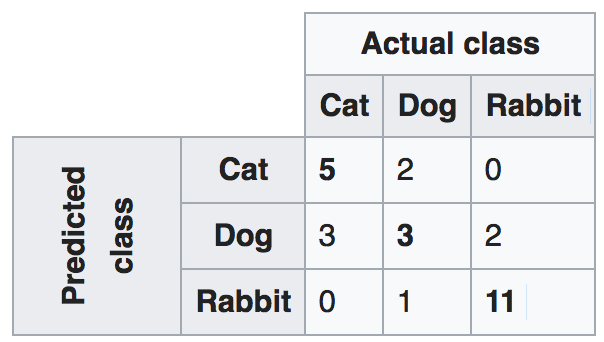

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

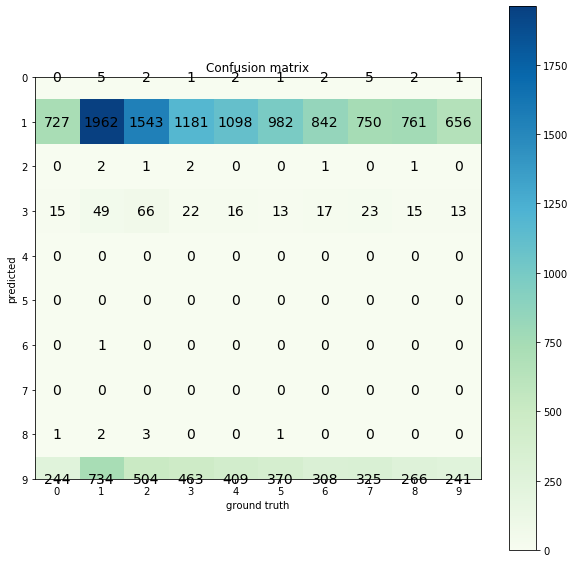

In [24]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for pred, gt in zip(predictions, ground_truth):
        confusion_matrix[pred][gt] += 1
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [31]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    cur_inds = []
    for ind, (pred, gt) in enumerate(zip(predictions, ground_truth)):
        if pred == predicted_class and gt == gt_class:
            cur_inds.append(ind)
            
    visualize_images(val_indices[cur_inds], 
                     data, 
                     title='pred={pr}, gt={gt}'.format(pr=predicted_class, gt=gt_class))

In [32]:
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)

<Figure size 720x108 with 0 Axes>

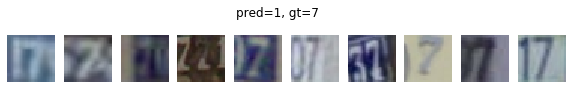

In [29]:
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

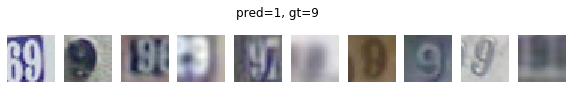

In [33]:
visualize_predicted_actual(1, 9, predictions, gt, np.array(val_indices), data_train_images)

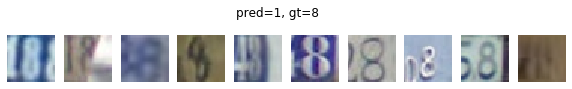

In [34]:
visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [45]:
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
#lr_lambda = lambda x: 0.5**(x//2)
#lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [36]:
%%time
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 5, lr_scheduler)

Epoch: 0 LR: [0.001]
Average loss: 2.097239, Train accuracy: 0.317049, Val accuracy: 0.471026
Epoch: 1 LR: [0.0005]
Average loss: 1.842107, Train accuracy: 0.483875, Val accuracy: 0.521671
Epoch: 2 LR: [0.0005]
Average loss: 1.728662, Train accuracy: 0.532369, Val accuracy: 0.560235
Epoch: 3 LR: [0.00025]
Average loss: 1.658617, Train accuracy: 0.562707, Val accuracy: 0.580779
Epoch: 4 LR: [0.00025]
Average loss: 1.619645, Train accuracy: 0.576852, Val accuracy: 0.595727
CPU times: user 9min 16s, sys: 1.02 s, total: 9min 17s
Wall time: 55.1 s


In [46]:
%%time
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
lr_lambda = lambda x: 0.5**(x//2)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 30, lr_scheduler, False)

Epoch: 0 LR: [0.001]
Average loss: 2.092313, Train accuracy: 0.332509, Val accuracy: 0.486247
Epoch: 1 LR: [0.0005]
Average loss: 1.846776, Train accuracy: 0.506518, Val accuracy: 0.544331
Epoch: 2 LR: [0.0005]
Average loss: 1.742343, Train accuracy: 0.548749, Val accuracy: 0.567538
Epoch: 3 LR: [0.00025]
Average loss: 1.673997, Train accuracy: 0.572842, Val accuracy: 0.595796
Epoch: 4 LR: [0.00025]
Average loss: 1.636008, Train accuracy: 0.583848, Val accuracy: 0.608832
Epoch: 5 LR: [0.000125]
Average loss: 1.607129, Train accuracy: 0.596219, Val accuracy: 0.616408
Epoch: 6 LR: [0.000125]
Average loss: 1.590236, Train accuracy: 0.599478, Val accuracy: 0.621050
Epoch: 7 LR: [6.25e-05]
Average loss: 1.575928, Train accuracy: 0.606064, Val accuracy: 0.618524
Epoch: 8 LR: [6.25e-05]
Average loss: 1.567924, Train accuracy: 0.608334, Val accuracy: 0.624121
Epoch: 9 LR: [3.125e-05]
Average loss: 1.560089, Train accuracy: 0.612531, Val accuracy: 0.623507
Epoch: 10 LR: [3.125e-05]
Average loss

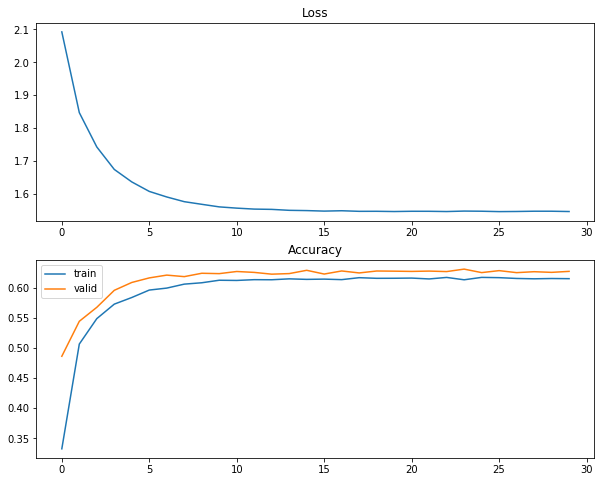

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

In [8]:
%%time
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
)
nn_model.cuda()
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
#lr_lambda = lambda x: 0.5**(x//2)
#lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 30, lr_scheduler, True)

Epoch: 0 LR: [0.001]
Average loss: 2.108077, Train accuracy: 0.301505, Val accuracy: 0.428571
Epoch: 1 LR: [0.001]
Average loss: 1.807429, Train accuracy: 0.486537, Val accuracy: 0.522831
Epoch: 2 LR: [0.001]
Average loss: 1.644882, Train accuracy: 0.551377, Val accuracy: 0.568425
Epoch: 3 LR: [0.001]
Average loss: 1.544430, Train accuracy: 0.581323, Val accuracy: 0.590949
Epoch: 4 LR: [0.001]
Average loss: 1.481582, Train accuracy: 0.599000, Val accuracy: 0.613473
Epoch: 5 LR: [0.001]
Average loss: 1.434115, Train accuracy: 0.617684, Val accuracy: 0.618320
Epoch: 6 LR: [0.001]
Average loss: 1.398594, Train accuracy: 0.629901, Val accuracy: 0.641117
Epoch: 7 LR: [0.001]
Average loss: 1.371155, Train accuracy: 0.643501, Val accuracy: 0.647123
Epoch: 8 LR: [0.001]
Average loss: 1.353122, Train accuracy: 0.654250, Val accuracy: 0.634701
Epoch: 9 LR: [0.00025]
Average loss: 1.310034, Train accuracy: 0.680545, Val accuracy: 0.683435
Epoch: 10 LR: [0.0005]
Average loss: 1.295930, Train accur

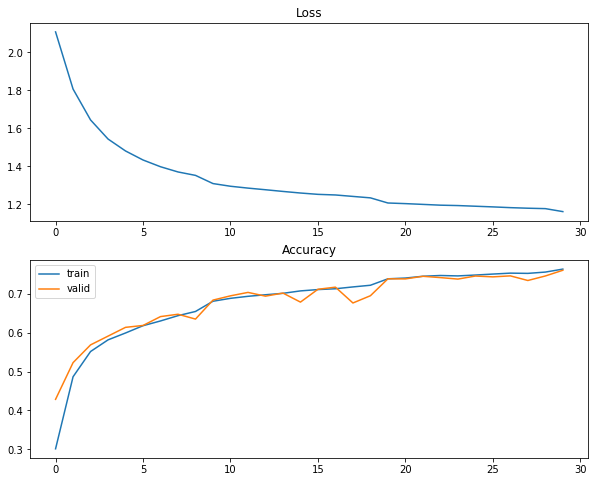

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

In [10]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=8)
test_accuracy = compute_accuracy(nn_model, test_loader, True)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7484


In [39]:
%%time
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10), 
)
nn_model.cuda()
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.9, nesterov=True)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
#lr_lambda = lambda x: 0.5**(x//2)
#lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 100, lr_scheduler, True)

Epoch: 0 LR: [0.0001]
Average loss: 1.630463, Train accuracy: 0.500239, Val accuracy: 0.669306
Epoch: 1 LR: [0.0001]
Average loss: 1.098813, Train accuracy: 0.669778, Val accuracy: 0.720633
Epoch: 2 LR: [0.0001]
Average loss: 0.925310, Train accuracy: 0.715968, Val accuracy: 0.755853
Epoch: 3 LR: [0.0001]
Average loss: 0.829511, Train accuracy: 0.742961, Val accuracy: 0.791482
Epoch: 4 LR: [0.0001]
Average loss: 0.770756, Train accuracy: 0.761185, Val accuracy: 0.781721
Epoch: 5 LR: [0.0001]
Average loss: 0.728636, Train accuracy: 0.773504, Val accuracy: 0.815644
Epoch: 6 LR: [0.0001]
Average loss: 0.693327, Train accuracy: 0.782104, Val accuracy: 0.820285
Epoch: 7 LR: [8.1e-05]
Average loss: 0.649900, Train accuracy: 0.797103, Val accuracy: 0.815303
Epoch: 8 LR: [9e-05]
Average loss: 0.633914, Train accuracy: 0.801693, Val accuracy: 0.824039
Epoch: 9 LR: [9e-05]
Average loss: 0.618867, Train accuracy: 0.807477, Val accuracy: 0.832366
Epoch: 10 LR: [9e-05]
Average loss: 0.607121, Train

Average loss: 0.292579, Train accuracy: 0.906068, Val accuracy: 0.876322
Epoch: 78 LR: [3.874204890000002e-05]
Average loss: 0.290955, Train accuracy: 0.905795, Val accuracy: 0.871749
Epoch: 79 LR: [3.138105960900002e-05]
Average loss: 0.284263, Train accuracy: 0.907006, Val accuracy: 0.878643
Epoch: 80 LR: [3.4867844010000016e-05]
Average loss: 0.283228, Train accuracy: 0.908559, Val accuracy: 0.880896
Epoch: 81 LR: [3.4867844010000016e-05]
Average loss: 0.279622, Train accuracy: 0.910146, Val accuracy: 0.872773
Epoch: 82 LR: [3.4867844010000016e-05]
Average loss: 0.277961, Train accuracy: 0.910760, Val accuracy: 0.877210
Epoch: 83 LR: [3.4867844010000016e-05]
Average loss: 0.277747, Train accuracy: 0.910606, Val accuracy: 0.876595
Epoch: 84 LR: [3.4867844010000016e-05]
Average loss: 0.278070, Train accuracy: 0.910777, Val accuracy: 0.878575
Epoch: 85 LR: [3.4867844010000016e-05]
Average loss: 0.274970, Train accuracy: 0.910743, Val accuracy: 0.876732
Epoch: 86 LR: [3.4867844010000016

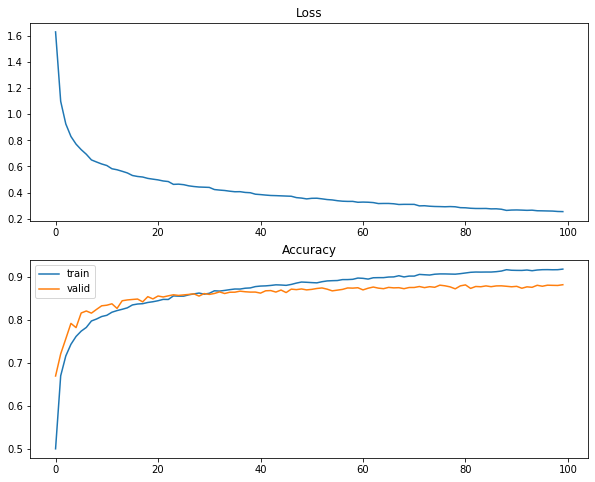

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

In [41]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=8)
test_accuracy = compute_accuracy(nn_model, test_loader, True)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8662


In [46]:
%%time
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10), 
)
nn_model.cuda()
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.9, nesterov=True)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.8)
#lr_lambda = lambda x: 0.5**(x//2)
#lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 100, lr_scheduler, True)

Epoch: 0 LR: [0.0001]
Average loss: 1.612798, Train accuracy: 0.501809, Val accuracy: 0.677223
Epoch: 1 LR: [0.0001]
Average loss: 1.104446, Train accuracy: 0.666263, Val accuracy: 0.715105
Epoch: 2 LR: [0.0001]
Average loss: 0.929835, Train accuracy: 0.714330, Val accuracy: 0.764385
Epoch: 3 LR: [0.0001]
Average loss: 0.832181, Train accuracy: 0.741818, Val accuracy: 0.756740
Epoch: 4 LR: [0.0001]
Average loss: 0.768923, Train accuracy: 0.761543, Val accuracy: 0.786226
Epoch: 5 LR: [0.0001]
Average loss: 0.726256, Train accuracy: 0.773027, Val accuracy: 0.803904
Epoch: 6 LR: [0.0001]
Average loss: 0.694374, Train accuracy: 0.783862, Val accuracy: 0.803426
Epoch: 7 LR: [6.400000000000001e-05]
Average loss: 0.639396, Train accuracy: 0.800362, Val accuracy: 0.823903
Epoch: 8 LR: [8e-05]
Average loss: 0.620997, Train accuracy: 0.804849, Val accuracy: 0.813460
Epoch: 9 LR: [8e-05]
Average loss: 0.604911, Train accuracy: 0.812033, Val accuracy: 0.834346
Epoch: 10 LR: [8e-05]
Average loss: 0

Average loss: 0.283765, Train accuracy: 0.910385, Val accuracy: 0.878234
Epoch: 77 LR: [1.3421772800000009e-05]
Average loss: 0.282337, Train accuracy: 0.910487, Val accuracy: 0.879599
Epoch: 78 LR: [1.3421772800000009e-05]
Average loss: 0.286633, Train accuracy: 0.908934, Val accuracy: 0.879667
Epoch: 79 LR: [8.589934592000007e-06]
Average loss: 0.277511, Train accuracy: 0.912040, Val accuracy: 0.879599
Epoch: 80 LR: [1.0737418240000008e-05]
Average loss: 0.276544, Train accuracy: 0.912125, Val accuracy: 0.876527
Epoch: 81 LR: [1.0737418240000008e-05]
Average loss: 0.275062, Train accuracy: 0.913098, Val accuracy: 0.878370
Epoch: 82 LR: [1.0737418240000008e-05]
Average loss: 0.273444, Train accuracy: 0.912125, Val accuracy: 0.878507
Epoch: 83 LR: [1.0737418240000008e-05]
Average loss: 0.276831, Train accuracy: 0.911323, Val accuracy: 0.877346
Epoch: 84 LR: [1.0737418240000008e-05]
Average loss: 0.273755, Train accuracy: 0.911204, Val accuracy: 0.879053
Epoch: 85 LR: [1.073741824000000

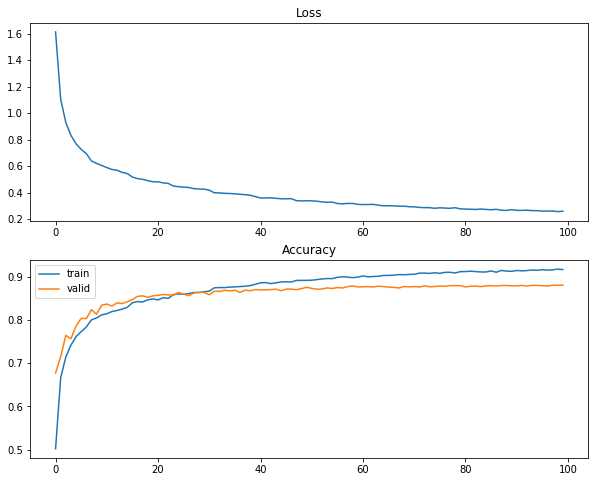

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

In [48]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=8)
test_accuracy = compute_accuracy(nn_model, test_loader, True)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8669


In [49]:
batch_size = 128

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=10)
val_loader = torch.utils.data.DataLoader(data_train, 
                                         batch_size=batch_size,
                                         sampler=val_sampler,
                                         num_workers=10)

In [50]:
%%time
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10), 
)
nn_model.cuda()
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.9, nesterov=True)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.8)
#lr_lambda = lambda x: 0.5**(x//2)
#lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, 100, lr_scheduler, True)

Epoch: 0 LR: [0.0001]
Average loss: 1.677817, Train accuracy: 0.493567, Val accuracy: 0.668009
Epoch: 1 LR: [0.0001]
Average loss: 1.133245, Train accuracy: 0.670085, Val accuracy: 0.727527
Epoch: 2 LR: [0.0001]
Average loss: 0.932668, Train accuracy: 0.721138, Val accuracy: 0.755034
Epoch: 3 LR: [0.0001]
Average loss: 0.829619, Train accuracy: 0.746647, Val accuracy: 0.764589
Epoch: 4 LR: [0.0001]
Average loss: 0.756558, Train accuracy: 0.767293, Val accuracy: 0.783564
Epoch: 5 LR: [0.0001]
Average loss: 0.706269, Train accuracy: 0.781729, Val accuracy: 0.802198
Epoch: 6 LR: [0.0001]
Average loss: 0.674107, Train accuracy: 0.789356, Val accuracy: 0.801857
Epoch: 7 LR: [6.400000000000001e-05]
Average loss: 0.628839, Train accuracy: 0.803911, Val accuracy: 0.813528
Epoch: 8 LR: [8e-05]
Average loss: 0.603249, Train accuracy: 0.810941, Val accuracy: 0.823357
Epoch: 9 LR: [8e-05]
Average loss: 0.582324, Train accuracy: 0.818688, Val accuracy: 0.832162
Epoch: 10 LR: [8e-05]
Average loss: 0

Average loss: 0.268105, Train accuracy: 0.914497, Val accuracy: 0.878848
Epoch: 77 LR: [1.3421772800000009e-05]
Average loss: 0.266862, Train accuracy: 0.915231, Val accuracy: 0.878916
Epoch: 78 LR: [1.3421772800000009e-05]
Average loss: 0.268476, Train accuracy: 0.915060, Val accuracy: 0.879189
Epoch: 79 LR: [8.589934592000007e-06]
Average loss: 0.261384, Train accuracy: 0.917346, Val accuracy: 0.878302
Epoch: 80 LR: [1.0737418240000008e-05]
Average loss: 0.261346, Train accuracy: 0.917380, Val accuracy: 0.878916
Epoch: 81 LR: [1.0737418240000008e-05]
Average loss: 0.264705, Train accuracy: 0.916647, Val accuracy: 0.878234
Epoch: 82 LR: [1.0737418240000008e-05]
Average loss: 0.257869, Train accuracy: 0.918507, Val accuracy: 0.879053
Epoch: 83 LR: [1.0737418240000008e-05]
Average loss: 0.257018, Train accuracy: 0.918268, Val accuracy: 0.877073
Epoch: 84 LR: [1.0737418240000008e-05]
Average loss: 0.257133, Train accuracy: 0.919462, Val accuracy: 0.879189
Epoch: 85 LR: [1.073741824000000

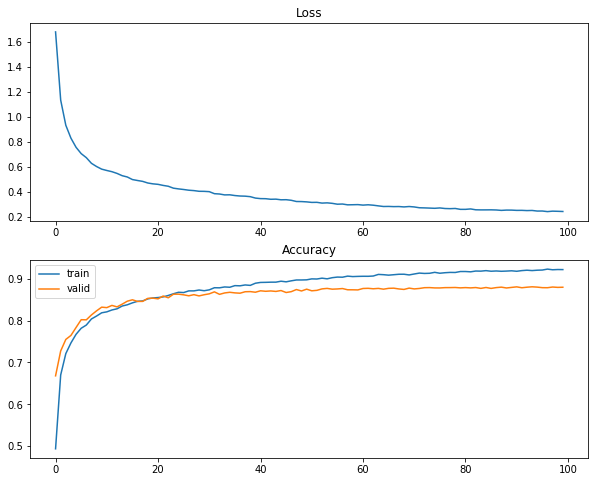

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

In [52]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=8)
test_accuracy = compute_accuracy(nn_model, test_loader, True)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8633
